# YNK forecast

## Import data

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve,auc
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from warnings import simplefilter
from sklearn.linear_model import LassoCV
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [2]:
# Import data in csv from github

# Import data from github
url = 'https://raw.githubusercontent.com/sagebhardt/forecast-AI-ynk/main/Base%20Analisis%20-%20Prueba%2001.1%20Forecasting%20en%20Belsport%20(Venta%20y%20Stock%20por%20marca%20y%20catergoria).csv'
df = pd.read_csv(url, sep=';')

# Remove '$' from column names
df.columns = df.columns.str.replace('$', '')

#print df size
print(df.shape)

df.head()

(54531, 11)


/var/folders/7n/r8rrh9ss6q9b_lyhlmx1x_hw0000gn/T/ipykernel_35592/173362198.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.replace('$', '')


,Semana,Tienda,Tipo mat,Grupo articulos,Sexo,Age Group,Entradas Tienda,Venta U,Venta Bruta,Costo Neto,Stock
0,W01,01-Ahumada,ZAPP,AD,Male,Adult,6857,2,46790,23194,89.0
1,W01,01-Ahumada,ZAPP,NI,Female,Adult,6857,1,26990,12520,118.0
2,W01,01-Ahumada,ZAPP,NI,Female,Pre School + Grade School,6857,3,73680,34777,18.0
3,W01,01-Ahumada,ZAPP,NI,Male,Adult,6857,19,593950,285666,270.0
4,W01,01-Ahumada,ZAPP,NI,Male,Grade School,6857,2,38980,18083,136.0


## Clean data  

In [3]:
#check for missing values
df.isnull().sum()

Semana                 0
Tienda                 0
Tipo mat               0
Grupo articulos        0
Sexo                1389
Age Group           1793
Entradas Tienda        0
Venta U                0
Venta Bruta            0
Costo Neto             0
Stock              16906
dtype: int64

In [4]:
#split features into categorical and numerical
categorical_features = df.select_dtypes(include=['object']).columns
numerical_features = df.select_dtypes(exclude=['object']).columns

print(categorical_features)
print(numerical_features)

Index(['Semana', 'Tienda', 'Tipo mat', 'Grupo articulos', 'Sexo', 'Age Group'], dtype='object')
Index(['Entradas Tienda', 'Venta U', 'Venta Bruta ', 'Costo Neto ', 'Stock'], dtype='object')


In [5]:
df_cat = pd.get_dummies(df[categorical_features], drop_first = True, dummy_na = True)
df_num = df[numerical_features]

from sklearn.impute import SimpleImputer
imp_num = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0, copy=True)
imp_num.fit(df_num)
df_num = pd.DataFrame(imp_num.transform(df_num), columns = df_num.columns)

df_binned = pd.concat([df_num, df_cat], axis = 1)

print(df_binned.shape)

df_binned.head()

(54531, 121)


,Entradas Tienda,Venta U,Venta Bruta,Costo Neto,Stock,Semana_W02,Semana_W03,Semana_W04,Semana_W05,Semana_W06,...,Sexo_Male,Sexo_Unisex,Sexo_nan,Age Group_Adult,Age Group_Full Family,Age Group_Grade School,Age Group_Pre School,Age Group_Pre School + Grade School,Age Group_Toddler,Age Group_nan
0,6857.0,2.0,46790.0,23194.0,89.0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
1,6857.0,1.0,26990.0,12520.0,118.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,6857.0,3.0,73680.0,34777.0,18.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,6857.0,19.0,593950.0,285666.0,270.0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,6857.0,2.0,38980.0,18083.0,136.0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


In [6]:
#Remove Venta U, Venta Bruta and Costo Neto from numerical features
numerical_features = numerical_features.drop(['Venta U', 'Venta Bruta ', 'Costo Neto '])

numerical_features

Index(['Entradas Tienda', 'Stock'], dtype='object')

In [7]:
#Get features and target
y = df_binned['Venta Bruta ']
X = df_binned.drop(['Venta Bruta ', 'Venta U', 'Costo Neto '], axis = 1)

features = X.columns

In [8]:
from sklearn.preprocessing import StandardScaler
import warnings; warnings.filterwarnings('ignore')

features = X.copy()
p = features.shape[1]

# for i in range(p):    
#     for j in range(p):
#         # Adding two-way interactions
#         if (i<=j):
#             var1 = features.columns.values[i]
#             var2 = features.columns.values[j]
#             colnam_two_way = var1+'_'+var2
#             features[colnam_two_way]=features[var1]*features[var2]
            
#             # Adding three-way interactions        
#             for k in range(p):
#                 if (j<=k): # i is already guaranteed to be less than j
#                     var3 = features.columns.values[k]                      
#             colnam_three_way = colnam_two_way+'_'+var3
#             features[colnam_three_way]=features[colnam_two_way]*features[var3]


for var in numerical_features:
    colnam_log = 'log1px2_'+var
    features[colnam_log]=np.log(1+features[var]*features[var])
    
    colnam_sqrt = 'sqrtAbs_'+var
    features[colnam_sqrt]=np.sqrt(np.abs(features[var]))    
                                    
featNames = features.columns.values            

# Scaling the columns to avoid having potential numerical issues as we have some very large numbers
features_scaled = pd.DataFrame(StandardScaler().fit_transform(features), columns = features.columns)

dataProcessed = features_scaled
X = dataProcessed
dataProcessed

,Entradas Tienda,Stock,Semana_W02,Semana_W03,Semana_W04,Semana_W05,Semana_W06,Semana_W07,Semana_W08,Semana_W09,...,Age Group_Full Family,Age Group_Grade School,Age Group_Pre School,Age Group_Pre School + Grade School,Age Group_Toddler,Age Group_nan,log1px2_Entradas Tienda,sqrtAbs_Entradas Tienda,log1px2_Stock,sqrtAbs_Stock
0,0.060107,-0.005532,-0.284867,-0.280745,-0.283887,-0.300488,-0.302875,-0.311633,-0.319188,-0.330641,...,-0.050916,-0.428280,-0.456849,-0.272136,-0.321311,-0.184386,0.248507,0.210510,0.805719,0.436945
1,0.060107,0.141452,-0.284867,-0.280745,-0.283887,-0.300488,-0.302875,-0.311633,-0.319188,-0.330641,...,-0.050916,-0.428280,-0.456849,-0.272136,-0.321311,-0.184386,0.248507,0.210510,0.935374,0.639539
2,0.060107,-0.365388,-0.284867,-0.280745,-0.283887,-0.300488,-0.302875,-0.311633,-0.319188,-0.330641,...,-0.050916,-0.428280,-0.456849,3.674633,-0.321311,-0.184386,0.248507,0.210510,0.071622,-0.299150
3,0.060107,0.911848,-0.284867,-0.280745,-0.283887,-0.300488,-0.302875,-0.311633,-0.319188,-0.330641,...,-0.050916,-0.428280,-0.456849,-0.272136,-0.321311,-0.184386,0.248507,0.210510,1.315900,1.429168
4,0.060107,0.232683,-0.284867,-0.280745,-0.283887,-0.300488,-0.302875,-0.311633,-0.319188,-0.330641,...,-0.050916,2.334919,-0.456849,-0.272136,-0.321311,-0.184386,0.248507,0.210510,1.000639,0.752849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54526,-0.980113,-0.132242,-0.284867,-0.280745,-0.283887,-0.300488,-0.302875,-0.311633,-0.319188,-0.330641,...,-0.050916,-0.428280,-0.456849,-0.272136,-0.321311,-0.184386,-0.385444,-1.021871,0.654148,0.233617
54527,-0.980113,-0.350183,-0.284867,-0.280745,-0.283887,-0.300488,-0.302875,-0.311633,-0.319188,-0.330641,...,-0.050916,-0.428280,-0.456849,-0.272136,-0.321311,-0.184386,-0.385444,-1.021871,0.142302,-0.250949
54528,-0.980113,-0.411004,-0.284867,-0.280745,-0.283887,-0.300488,-0.302875,-0.311633,-0.319188,-0.330641,...,-0.050916,-0.428280,2.188907,-0.272136,-0.321311,-0.184386,-0.385444,-1.021871,-0.244929,-0.475347
54529,-0.980113,-0.284294,-0.284867,-0.280745,-0.283887,-0.300488,-0.302875,-0.311633,-0.319188,-0.330641,...,-0.050916,-0.428280,-0.456849,-0.272136,-0.321311,-0.184386,-0.385444,-1.021871,0.363498,-0.073938


In [9]:
#Add Venta Bruta to dataProcessed
dataProcessed['Venta Bruta '] = df_binned['Venta Bruta ']
y=dataProcessed['Venta Bruta ']

In [10]:
#Generate mock_test and mock_train using trainig_processed
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataProcessed, test_size=0.2, random_state=42)

y_train = train['Venta Bruta ']
y_test = test['Venta Bruta ']
X_train = train.drop(['Venta Bruta '], axis = 1)
X_test = test.drop(['Venta Bruta '], axis = 1)

X_test.head()

,Entradas Tienda,Stock,Semana_W02,Semana_W03,Semana_W04,Semana_W05,Semana_W06,Semana_W07,Semana_W08,Semana_W09,...,Age Group_Full Family,Age Group_Grade School,Age Group_Pre School,Age Group_Pre School + Grade School,Age Group_Toddler,Age Group_nan,log1px2_Entradas Tienda,sqrtAbs_Entradas Tienda,log1px2_Stock,sqrtAbs_Stock
13852,-0.229115,-0.132242,-0.284867,-0.280745,3.522522,-0.300488,-0.302875,-0.311633,-0.319188,-0.330641,...,-0.050916,-0.428280,-0.456849,-0.272136,3.112245,-0.184386,0.120998,-0.083210,0.654148,0.233617
41289,0.688771,1.018285,-0.284867,-0.280745,-0.283887,-0.300488,-0.302875,-0.311633,-0.319188,-0.330641,...,-0.050916,-0.428280,-0.456849,-0.272136,-0.321311,-0.184386,0.465609,0.775204,1.350334,1.518079
53845,-1.109915,-0.456619,-0.284867,-0.280745,-0.283887,-0.300488,-0.302875,-0.311633,-0.319188,-0.330641,...,-0.050916,-0.428280,-0.456849,-0.272136,-0.321311,5.423401,-0.525923,-1.228391,-1.257889,-0.900726
9931,-0.519367,-0.456619,-0.284867,3.561952,-0.283887,-0.300488,-0.302875,-0.311633,-0.319188,-0.330641,...,-0.050916,2.334919,-0.456849,-0.272136,-0.321311,-0.184386,-0.035013,-0.408626,-1.257889,-0.900726
11509,-0.754762,-0.456619,-0.284867,3.561952,-0.283887,-0.300488,-0.302875,-0.311633,-0.319188,-0.330641,...,-0.050916,-0.428280,2.188907,-0.272136,-0.321311,-0.184386,-0.192665,-0.703216,-1.257889,-0.900726


## Test Models

### LassoCV

In [11]:
def rmse(actual,prediction):
    residuals = actual-prediction
    return (np.sqrt(np.mean( residuals**2  )))

In [12]:
trainingPredictorsAsMatrix = np.asarray(X_train)
validationPredictorsAsMatrix = np.asarray(X_test)

In [13]:
my_lambdas=np.exp(np.arange(0,10,0.1))
nfolds = 5

model=LassoCV(cv=nfolds,
              alphas = my_lambdas,
              max_iter=1000,
              tol=1e-5,
              selection='random',
                   ).fit(trainingPredictorsAsMatrix,y_train)

predLasso=model.predict(validationPredictorsAsMatrix)
vRMSE = rmse(y_test,predLasso)
print('validation RMSE=',vRMSE)

validation RMSE= 556599.7778514259


Best RMSE achieved at log(lambda)= 3.1

   with average RMSE = 562062.446162422 and SE= 10928.534996800645


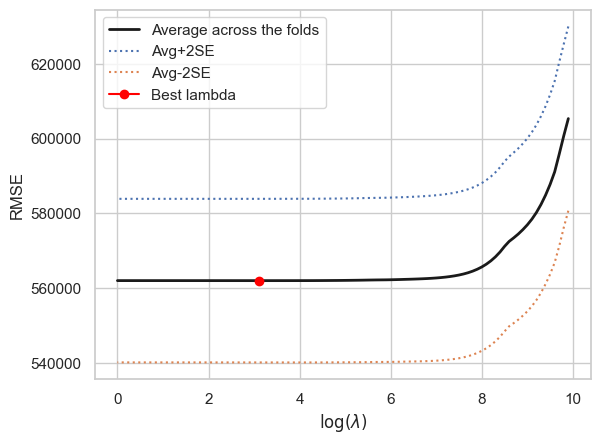

In [14]:
plt.figure()
log_lambdas = np.log(model.alphas_)

avg = np.sqrt(model.mse_path_).mean(axis=-1)
se = np.sqrt(model.mse_path_).std(axis=-1)/np.sqrt(nfolds)

min_index = np.argmin(avg)
print('Best RMSE achieved at log(lambda)=',log_lambdas[min_index])
print('\n   with average RMSE =',avg[min_index], 'and SE=',se[min_index])
plt.plot(log_lambdas,avg, 'k', label='Average across the folds', linewidth=2)
plt.plot(log_lambdas,avg+2*se , ':',label='Avg+2SE')
plt.plot(log_lambdas,avg-2*se , ':',label='Avg-2SE')
plt.plot(log_lambdas[min_index],avg[min_index], marker ='o', color ='red', label = 'Best lambda')

plt.legend()

plt.xlabel('$\log(\lambda)$')  # This is latex syntax
plt.ylabel('RMSE')
plt.axis('tight')
plt.show()

In [15]:
features_names = list(featNames)
features_names.append('intercept')
all_coeff = np.append(model.coef_,model.intercept_)

coefficients_matrix = pd.DataFrame(data = {'Features': features_names, 'Coefficient':all_coeff})

nnz = np.sum(np.abs(all_coeff)>0)
print('There are',nnz,'non-zero coefficients selected by Lasso\n\n', coefficients_matrix.loc[np.abs(all_coeff)>0,:])

There are 119 non-zero coefficients selected by Lasso

                     Features   Coefficient
0            Entradas Tienda  1.651970e+04
1                      Stock -3.715637e+05
2                 Semana_W02  4.211241e+02
3                 Semana_W03 -1.781956e+03
4                 Semana_W04 -6.650797e+02
..                       ...           ...
118  log1px2_Entradas Tienda -2.765792e+05
119  sqrtAbs_Entradas Tienda  2.314776e+05
120            log1px2_Stock -5.514121e+05
121            sqrtAbs_Stock  1.020295e+06
122                intercept  3.755532e+05

[119 rows x 2 columns]


### Random Forest

In [16]:
# Use random forest to predict the target variable
from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
rf = RandomForestRegressor(n_estimators=1000)

# Train the model on training data
rf.fit(X_train, y_train);

# Use the forest's predict method on the test data
predRF = rf.predict(X_test)

vRMSE = rmse(y_test,predRF)
print('validation RMSE=',vRMSE)

validation RMSE= 293779.3193292205


In [17]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: log1px2_Stock        Importance: 0.1
Variable: sqrtAbs_Stock        Importance: 0.1
Variable: Stock                Importance: 0.09
Variable: Entradas Tienda      Importance: 0.07
Variable: Tienda_501 - Belsport Virtual Importance: 0.07
Variable: log1px2_Entradas Tienda Importance: 0.07
Variable: sqrtAbs_Entradas Tienda Importance: 0.07
Variable: Tipo mat_ZFOO        Importance: 0.06
Variable: Grupo articulos_NI   Importance: 0.04
Variable: Sexo_Male            Importance: 0.04
Variable: Sexo_Female          Importance: 0.03
Variable: Age Group_Adult      Importance: 0.03
Variable: Grupo articulos_PM   Importance: 0.02
Variable: Age Group_Grade School Importance: 0.02
Variable: Semana_W07           Importance: 0.01
Variable: Semana_W08           Importance: 0.01
Variable: Semana_W09           Importance: 0.01
Variable: Tipo mat_ZEQU        Importance: 0.01
Variable: Grupo articulos_CR   Importance: 0.01
Variable: Grupo articulos_CV   Importance: 0.01
Variable: Grupo articulos

### GBM

In [18]:
# use gbm to predict the target variable
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate model with 1000 decision trees
gbm = GradientBoostingRegressor(n_estimators=1000)

# Train the model on training data
gbm.fit(X_train, y_train)

# Use the predict method on the test data
predGBM = gbm.predict(X_test)

vRMSE = rmse(y_test,predGBM)
print('validation RMSE=',vRMSE)

validation RMSE= 400481.43209975876


### XGBoost

In [22]:
# regression using xgboost
import xgboost as xgb

# Instantiate model with 1000 decision trees
modelXGB = xgb.XGBRegressor(n_estimators=1000)

# Train the model on training data
modelXGB.fit(X_train, y_train)

# Use the predict method on the test data
predXGB = modelXGB.predict(X_test)

vRMSE = rmse(y_test,predXGB)
print('validation RMSE=',vRMSE)

validation RMSE= 288933.5728984313


### CatBoost

In [20]:
# regression using catboost
from catboost import CatBoostRegressor

# Instantiate model with 1000 decision trees
cat = CatBoostRegressor(n_estimators=10000, verbose=False)

# Train the model on training data
cat.fit(X_train, y_train)

# Use the predict method on the test data
predCAT = cat.predict(X_test)

vRMSE = rmse(y_test,predCAT)
print('validation RMSE=',vRMSE)


validation RMSE= 303631.47907974495


## 5-Fold Cross Validation

In [23]:
nFolds = 5

kf = KFold(n_splits=nFolds, random_state=None, shuffle=True)

RMSEList = pd.DataFrame(columns = ['RF_RMSE','XGB_RMSE','CATBOOST_RMSE'])
RMSEList.RF_RMSE = np.zeros(nFolds)
RMSEList.XGB_RMSE = np.zeros(nFolds)
RMSEList.CATBOOST_RMSE = np.zeros(nFolds)


i=0
for train_index, valid_index in kf.split(dataProcessed):
    
    train_cv = dataProcessed.iloc[train_index,:]
    valid_cv = dataProcessed.iloc[valid_index,:]
    

    # Random Forest Model
    modelRF = RandomForestRegressor(n_estimators=100)
    RFtrain_cv = modelRF.fit(train_cv.loc[:,featNames],train_cv['Venta Bruta '])
    validProbsRF_cv  = RFtrain_cv.predict(valid_cv.loc[:,featNames])
    validProbsRF_cv = validProbsRF_cv.reshape(validProbsRF_cv.shape[0], )
    RMSEList.RF_RMSE[i]= rmse(valid_cv['Venta Bruta '], validProbsRF_cv)
    
    # XGB Model
    modelXGB = xgb.XGBRegressor(n_estimators=1000)
    XGBtrain_cv = modelXGB.fit(train_cv.loc[:,featNames],train_cv['Venta Bruta '])
    validationProbsXGB  = XGBtrain_cv.predict(valid_cv.loc[:,featNames])
    validationProbsXGB = validationProbsXGB.reshape(validationProbsXGB.shape[0], )
    RMSEList.XGB_RMSE[i]= rmse(valid_cv['Venta Bruta '], validationProbsXGB)
    
    # CatBoost Model
    modelCB = CatBoostRegressor(iterations=100, verbose=False)
    CBtrain_cv = modelCB.fit(train_cv.loc[:,featNames],train_cv['Venta Bruta '])
    probsCB  = CBtrain_cv.predict(valid_cv.loc[:,featNames])
    probsCB = probsCB.reshape(probsCB.shape[0], )
    RMSEList.CATBOOST_RMSE[i]= rmse(valid_cv['Venta Bruta '], probsCB)  
    
    i = i + 1
    print('Finished fold',i)

Finished fold 1
Finished fold 2
Finished fold 3
Finished fold 4
Finished fold 5


In [24]:
print('     RF avg RMSE =',np.round(np.mean(RMSEList.RF_RMSE),4),
      ' and SE(RMSE) =', np.round(np.std(RMSEList.RF_RMSE)/np.sqrt(nFolds),4) )
print('     XGB avg RMSE =',np.round(np.mean(RMSEList.XGB_RMSE),4),
      ' and SE(RMSE) =', np.round(np.std(RMSEList.XGB_RMSE)/np.sqrt(nFolds),4) )
print('Catboost avg RMSE =',np.round(np.mean(RMSEList.CATBOOST_RMSE),4),
      ' and SE(RMSE) =', np.round(np.std(RMSEList.CATBOOST_RMSE)/np.sqrt(nFolds),4) )
RMSEList

     RF avg RMSE = 285372.3053  and SE(RMSE) = 650.2423
     XGB avg RMSE = 281789.0231  and SE(RMSE) = 2577.7385
Catboost avg RMSE = 335806.4522  and SE(RMSE) = 2601.3298


,RF_RMSE,XGB_RMSE,CATBOOST_RMSE
0,287977.165217,288100.663818,339796.170506
1,283968.358169,273952.696823,330475.936248
2,284274.145450,287419.094061,341561.380701
3,285869.918257,276218.605099,327197.075125
4,284771.939428,283254.055557,340001.698386


## Neural Network

In [38]:
# Neural Network regression
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# create model
model = Sequential()
model.add(Dense(1000, input_dim=featNames.size, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dense(50, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# Compile model
model.compile(loss = root_mean_squared_error, optimizer='adam')

print(model.summary())
print('Stay tuned, we are now training the model ...')

history = model.fit(X_train, y_train, epochs = 30, verbose = True, validation_data=(X_test, y_test))
preds = model.predict(X_test)
preds = preds.reshape(preds.shape[0], )
print('RMSE =', rmse(y_test,preds))




Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 1000)              123000    
                                                                 
 dense_29 (Dense)            (None, 100)               100100    
                                                                 
 dense_30 (Dense)            (None, 50)                5050      
                                                                 
 dense_31 (Dense)            (None, 1)                 51        
                                                                 
Total params: 228,201
Trainable params: 228,201
Non-trainable params: 0
_________________________________________________________________
None
Stay tuned, we are now training the model ...
Epoch 1/30
   1/1364 [..............................] - ETA: 6:46 - loss: 792941.3125

2023-04-01 19:28:28.914563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1364/1364 [==============================] - ETA: 0s - loss: 519815.0312

2023-04-01 19:28:37.674794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1364/1364 [==============================] - 10s 7ms/step - loss: 519815.0312 - val_loss: 428517.5625
Epoch 2/30
1364/1364 [==============================] - 9s 7ms/step - loss: 429428.0312 - val_loss: 395470.1250
Epoch 3/30
1364/1364 [==============================] - 9s 7ms/step - loss: 398111.8125 - val_loss: 368279.1562
Epoch 4/30
1364/1364 [==============================] - 9s 7ms/step - loss: 371952.7500 - val_loss: 346595.1875
Epoch 5/30
1364/1364 [==============================] - 9s 7ms/step - loss: 348539.0000 - val_loss: 330679.2500
Epoch 6/30
1364/1364 [==============================] - 9s 7ms/step - loss: 329504.6562 - val_loss: 315051.4062
Epoch 7/30
1364/1364 [==============================] - 9s 7ms/step - loss: 313695.5938 - val_loss: 302618.3750
Epoch 8/30
1364/1364 [==============================] - 9s 7ms/step - loss: 299746.7500 - val_loss: 293125.9375
Epoch 9/30
1364/1364 [==============================] - 9s 7ms/step - loss: 287098.8438 - val_loss: 281698.0625
Ep

2023-04-01 19:33:01.077033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


341/341 [==============================] - 1s 2ms/step
RMSE = 251114.4945019019


In [39]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


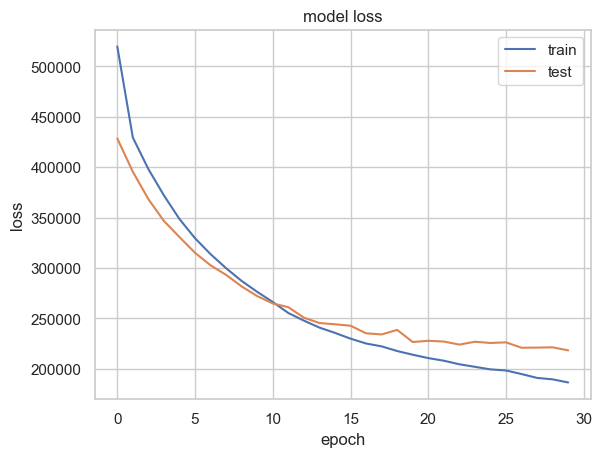

In [40]:
#plot loss vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Results Total

In [42]:
predANNFinal = model.predict(dataProcessed.loc[:,featNames])

# Get sum of all predictions
predANNFinal = predANNFinal.reshape(predANNFinal.shape[0], )
predANNFinal = np.sum(predANNFinal)

print('Total predicted sales =',predANNFinal)

1705/1705 [==============================] - 3s 2ms/step
Total predicted sales = 20336572000.0


In [43]:
#Get sum of all actual sales
actualSales = dataProcessed['Venta Bruta ']
actualSales = np.sum(actualSales)

print('Total actual sales =',actualSales)

Total actual sales = 20361279082.0


In [44]:
#Get percentage error
print('Percentage error =',np.round(100*(predANNFinal-actualSales)/actualSales,2),'%')

Percentage error = -0.12 %


## Results by Week

In [53]:
#Create a dataframe to store predicted sales, actual sales and percentage error
resultsW = pd.DataFrame(columns=['Week','Predicted Sales','Actual Sales','Percentage Error'])

for i in range(1, 13):
    if(i<10):
        week="W0"+str(i)
    else:
        week="W"+str(i)

    indicesW = df[df['Semana'] == week].index

    predANNWeek = model.predict(dataProcessed.loc[indicesW,featNames])
    predANNWeek = predANNWeek.reshape(predANNWeek.shape[0], )

    # Get actual sales for W01
    actualSalesWeek= dataProcessed.loc[indicesW,'Venta Bruta ']
    actualSalesWeek = np.sum(actualSalesWeek)

    # Store predicted sales, actual sales and percentage error in dataframe
    resultsW = resultsW.append({'Week':week,'Predicted Sales':np.sum(predANNWeek),'Actual Sales':actualSalesWeek,'Percentage Error':np.round(100*(np.sum(predANNWeek)-actualSalesWeek)/actualSalesWeek,2)}, ignore_index=True)

resultsW


139/139 [==============================] - 0s 2ms/step


,Week,Predicted Sales,Actual Sales,Percentage Error
0,W01,1.193322e+09,1.230103e+09,-2.99
1,W02,1.075449e+09,1.153976e+09,-6.80
2,W03,1.150337e+09,1.125203e+09,2.23
3,W04,1.249344e+09,1.227007e+09,1.82
4,W05,1.656773e+09,1.690819e+09,-2.01
5,W06,1.760283e+09,1.706535e+09,3.15
6,W07,2.026632e+09,1.987334e+09,1.98
7,W08,2.520677e+09,2.600788e+09,-3.08
8,W09,3.644278e+09,3.595522e+09,1.36
9,W10,1.602594e+09,1.611867e+09,-0.58
